# Linear regression with real data

## Earth temperature over time

In this lesson, we will apply all that we've learned (and more) to analyze real data of Earth temperature over time.

Is global temperature rising? How much? This is a question of burning importance in today's world!

Data about global temperatures are available from several sources: NASA, the National Climatic Data Center (NCDC) and the University of East Anglia in the UK. Check out an article by the [University Corporation for Atmospheric Research](https://scied.ucar.edu/learning-zone/how-climate-works/why-earth-warming) (UCAR) for an in-depth discussion.

The NASA Goddard Space Flight Center Scientific Visualization Studio is one of our sources of global climate data. They have produced animations showing a color map of the changing global surface **temperature anomalies** since 1880—see the updated [video with 2023 data](https://svs.gsfc.nasa.gov/5207/) on their website.

The term [global temperature anomaly](https://www.ncdc.noaa.gov/monitoring-references/faq/anomalies.php) means the difference in temperature with respect to a reference value or a long-term average. It is a very useful way of looking at the problem and in many ways better than absolute temperature. For example, a winter month may be colder than average in Washington DC, and also in Miami, but the absolute temperatures will be different in both places.

The YouTube video embedded below shows the global temperature anomaly from 1880 to 2022.

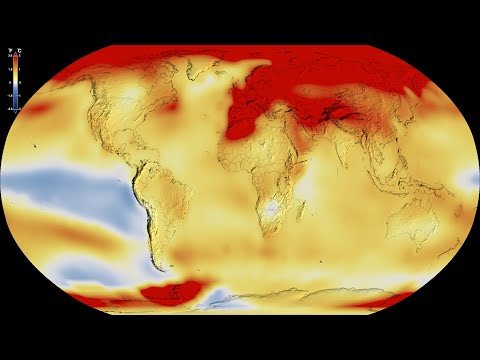

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('LwRTw_7NNJs')

How would we go about understanding the _trends_ from the data on global temperature?

The first step in analyzing unknown data is to generate some simple plots using **Matplotlib**. We are going to look at the temperature-anomaly history, contained in a file, and make our first plot to explore this data. 

We are going to smooth the data and then we'll fit a line to it to find a trend, plotting along the way to see how it all looks.

Let's get started!

## Step 1: Read a data file

We obtained time-series data from the [NOAA](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series) (National Oceanic and Atmospheric Administration) webpage. Feel free to play around with the webpage and analyze data on your own, but for now, let's make sure we're working with the same dataset.


If you made a copy of the full set of files for this module, you will have a file named `land_global_temperature_anomaly-1850-2023.csv` in the `data` folder. This comma-separated data file shows the year on the first column, and averages of land temperature anomaly on the second column, between the years 1850 and 2023. We will load the file, then make an initial plot to see what it looks like.


**Note:**

If you downloaded this notebook alone, or are following along in your own notebook, you may not have the data file on the location we assume below. In that case, you can download the data if you add a code cell, and execute the following code in it:

```Python
from urllib.request import urlretrieve
URL = 'http://go.gwu.edu/engcomp1data5'
urlretrieve(URL, 'land_global_temperature_anomaly-1850-2023.csv')
```
</br>

The data file will be downloaded to your working directory, and you will then need to remove the path information, i.e., the string `'../data/'`, from the definition of the variable `fname` below.

Let's start by taking a peek at the data.

In [2]:
# modify the path to the data file as needed
!head ../data/land_global_temperature_anomaly-1850-2023.csv

Global Land and Ocean December Temperature Anomalies
Units: Degrees Celsius
Base Period: 1901-2000
Missing: -999
Year,Anomaly
1850,-0.07
1851,-0.03
1852,-0.09
1853,-0.22
1854,0.01


One thing we notice right away is that a few lines in the file have some header information. Count the lines: including the column labels, five lines should be skipped if we want to load the numeric data into NumPy arrays.

Next, import the fantastic NumPy library for array operations, and let the fun begin!

In [3]:
import numpy

To load our data from the file, we'll use the function [`numpy.loadtxt()`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html), which lets us immediately save the data into NumPy arrays. (We encourage you to read the documentation for details on how the function works.) Here, we'll save the data into the arrays `year` and `temp_anomaly`. 

In [4]:
fname = '../data/land_global_temperature_anomaly-1850-2023.csv'

year, temp_anomaly = numpy.loadtxt(fname, delimiter=',', skiprows=5, unpack=True)

_Exercise:_

Inspect the data by printing a slice of`year` and `temp_anomaly`.

## Step 2: Plot the data

Let's first load the **Matplotlib** module called `pyplot`, for making 2D plots. Remember that to get the plots inside the notebook, we use a special "magic" command, `%matplotlib inline`:

In [5]:
from matplotlib import pyplot
%matplotlib inline

The `plot()` function of the `pyplot` module makes simple line plots. We avoid that stuff that appeared on top of the figure, that `Out[x]: [< ...>]` ugliness, by adding a semicolon at the end of the plotting command.

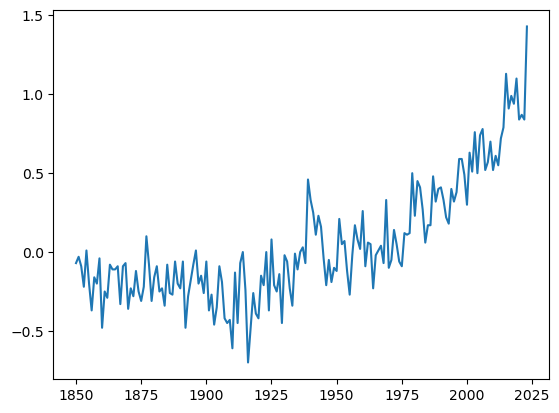

In [6]:
pyplot.plot(year, temp_anomaly);

Now we have a line plot, but if you see this plot without any information you would not be able to figure out what kind of data it is! We need labels on the axes, a title and why not a better color, font and size of the ticks.

*Publication quality* plots should always be your standard for plotting. 
How you present your data will allow others (and probably you in the future) to better understand your work. 

We can customize the style of our plots using parameters for the lines, text, font and other plot options. We set some style options that apply for all the plots in the current session with [`pyplot.rc()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.rc.html)
Here, we'll make the font of a specific type and size (serif and 16 points). You can also customize other parameters like line width, color, and so on (check out the documentation).

In [7]:
pyplot.rc('font', family='serif', size='16')

We'll redo the same plot, but now we'll add a few things to make it prettier and **publication quality**. We'll add a title, label the axes and, show a background grid. Study the commands below and look at the result!

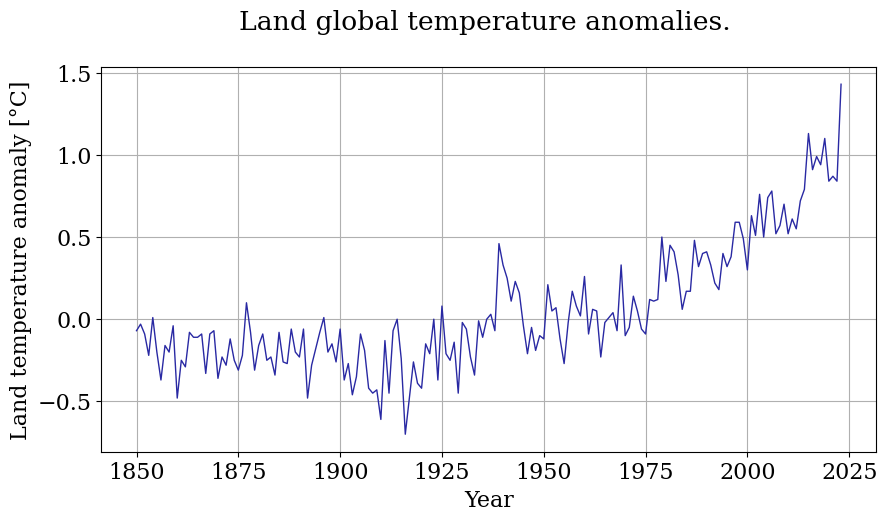

In [8]:
#You can set the size of the figure by doing:
pyplot.figure(figsize=(10,5))

#Plotting
pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1) 
pyplot.title('Land global temperature anomalies. \n')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.grid();

Better, no? Feel free to play around with the parameters and see how the plot changes. There's nothing like trial and error to get the hang of it. 

## Step 3: Least-squares linear regression 

In order to have an idea of the general behavior of our data, we can find a smooth curve that (approximately) fits the points. We generally look for a curve that's simple (e.g., a polynomial), and does not reproduce the noise that's always present in experimental data. 

Let $f(x)$ be the function that we'll fit to the $n+1$ data points: $(x_i, y_i)$, $i = 0, 1, ... ,n$:

$$ 
    f(x) = f(x; a_0, a_1, ... , a_m) 
$$

The notation above means that $f$ is a function of $x$, with $m+1$ variable parameters $a_0, a_1, ... , a_m$, where $m < n$. We need to choose the form of $f(x)$ a priori, by inspecting the experimental data and knowing something about the phenomenon we've measured. Thus, curve fitting consists of two steps: 

1. Choosing the form of $f(x)$.
2. Computing the parameters that will give us the "best fit" to the data. 


### What is the "best" fit to the data?

When the noise in the data is limited to the $y$-coordinate, it's common to use a **least-squares fit**, which minimizes the function

$$
\begin{align}    
    S(a_0, a_1, ... , a_m) = \sum_{i=0}^{n} [y_i - f(x_i)]^2 
\end{align}    
$$

with respect to each $a_j$. 
Here, the terms $r_i = y_i - f(x_i)$ are called _residuals_: they are the discrepancy between the data and the fitting function at the $x_i$ values, as illustrated in the figure below.

<img src="../images/residuals.png" alt="A fitting line, and the residuals of the data" width="400">

We compute the parameters for the best fit by taking the derivative of $S$ with respect to the parameters and equating to zero, then solving the resulting equations:

$$
\begin{align}
    \frac{\partial{S}}{\partial{a_k}} = 0, \quad k = 0, 1, ... , m.
\end{align}
$$

You may remember this from calculus, but if not, look at the figure below and imagine that the curve represents the function $S$ with respect to some parameter $a_k$. Visualize the slope of the tangent to the curve at several points, and you can see that when the slope is horizontal (zero) we've found the minimum of the function.

<img src="../images/find_the_min.png" alt="A U-shaped curve with points approaching the minimum" width="400">

Take another look at the function $S$: what we want to minimize is the sum of the squares of the residuals. The equations in $(2)$ are generally nonlinear with respect to $a_k$ and might be difficult to solve. Therefore, the fitting function is commonly chosen as a linear combination of functions $f_j(x)$ with a simple form:

$$
\begin{equation*}
    f(x) = a_0f_0(x) + a_1f_1(x) + ... + a_mf_m(x)
\end{equation*}
$$

resulting in equations (2) being linear. For a polynomial fitting function, we have have $f_0(x) = 1, \; f_1(x) = x, \; f_2(x) = x^2$, and so on.  

### Linear regression 

When we talk about linear regression we mean "fitting a straight line to the data." Thus,

$$
\begin{align}
    f(x) = a_0 + a_1x
\end{align}
$$

In this case, the function that we need to minimize is:

$$
\begin{align}
    S(a_0, a_1) = \sum_{i=0}^{n} [y_i - f(x_i)]^2 = \sum_{i=0}^{n} (y_i - a_0 - a_1x_i)^2
\end{align}    
$$

Equations $(2)$ become:

$$
\begin{align}
    \frac{\partial{S}}{\partial{a_0}} &=  \sum_{i=0}^{n} -2(y_i - a_0 - a_1x_i) = 2 \left[ a_0(n+1) + a_1\sum_{i=0}^{n} x_i - \sum_{i=0}^{n} y_i \right] = 0 \nonumber \\
    \frac{\partial{S}}{\partial{a_1}} &=  \sum_{i=0}^{n} -2(y_i - a_0 - a_1x_i)x_i = 2 \left[ a_0\sum_{i=0}^{n} x_i + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i \right] = 0
\end{align}    
$$

Let's divide both equations by $2(n+1)$ and rearrange term: the first equation gives us $a_0$ as follows

$$
\begin{align}
    2 \left[ a_0(n+1) + a_1\sum_{i=0}^{n} x_i - \sum_{i=0}^{n} y_i \right] &= 0  \nonumber \\ 
    \frac{a_0(n+1)}{n+1} + a_1 \frac{\sum_{i=0}^{n} x_i}{n+1} - \frac{\sum_{i=0}^{n} y_i}{n+1} &= 0 \\
    a_0  &= \bar{y} - a_1\bar{x},
\end{align}
$$

where $\bar{x} = \frac{\sum_{i=0}^{n} x_i}{n+1}$ and $\bar{y} = \frac{\sum_{i=0}^{n} y_i}{n+1}$.

Rearranging the second equation:

$$
\begin{align}
    2 \left[ a_0\sum_{i=0}^{n} x_i + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i \right] &= 0 \nonumber \\
    a_0\sum_{i=0}^{n} x_i + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i &=0 \\
\end{align}
$$

Now we can replace the expression we found for $a_0$:

$$
\begin{align*}
    (\bar{y} - a_1\bar{x})\sum_{i=0}^{n} x_i  + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i  &= 0 \\ 
\end{align*}
$$

Replacing the definitions of the mean values into the equation,  

$$
\begin{align*}
    \left[\frac{1}{n+1}\sum_{i=0}^{n} y_i  - \frac{a_1}{n+1}\sum_{i=0}^{n} x_i \right]\sum_{i=0}^{n} x_i  + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i  &= 0  \\ 
     \frac{1}{n+1}\sum_{i=0}^{n} y_i \sum_{i=0}^{n} x_i - \frac{a_1}{n+1}\sum_{i=0}^{n} x_i \sum_{i=0}^{n} x_i  + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i  &= 0  \\ 
\end{align*}
$$

Leaving everything in terms of $\bar{x}$, 

$$
\begin{align*}
    \sum_{i=0}^{n} y_i \bar{x} - a_1\sum_{i=0}^{n} x_i \bar{x} + a_1\sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_iy_i  = 0  
\end{align*}
$$

Grouping the terms that have $a_1$ on the left-hand side and the rest on the right-hand side:

$$
\begin{align*}
    a_1\left[ \sum_{i=0}^{n} x_{i}^2 - \sum_{i=0}^{n} x_i \bar{x}\right] &= \sum_{i=0}^{n} x_iy_i - \sum_{i=0}^{n} y_i \bar{x} \\
    a_1 \sum_{i=0}^{n} (x_{i}^2 - x_i \bar{x}) &= \sum_{i=0}^{n} (x_iy_i -  y_i \bar{x}) \\
    a_1 \sum_{i=0}^{n} x_{i}(x_{i} -\bar{x}) &= \sum_{i=0}^{n} y_i(x_i - \bar{x})    
\end{align*}
$$

Finally, we get that:

$$
\begin{align}
    a_1 = \frac{ \sum_{i=0}^{n} y_{i} (x_i - \bar{x})}{\sum_{i=0}^{n} x_i (x_i - \bar{x})}
\end{align}
$$

Then our coefficients are:

$$
\begin{align}
    a_1 = \frac{ \sum_{i=0}^{n} y_{i} (x_i - \bar{x})}{\sum_{i=0}^{n} x_i (x_i - \bar{x})} \quad , \quad a_0  = \bar{y} - a_1\bar{x}
\end{align}
$$

### Let's fit!

Let's now fit a straight line through the temperature-anomaly data, to see the trend over time. We'll use least-squares linear regression to find the slope and intercept of a line 

$$y = a_1x+a_0$$

that fits our data.

In our case, the `x`-data corresponds to `year`, and the `y`-data is `temp_anomaly`. To calculate our coefficients with the formula above, we need the mean values of our data. Sine we'll need to compute the mean for both `x` and `y`, it could be useful to write a custom Python _function_ that computes the mean for any array, and we can then reuse it.

It is good coding practice to *avoid repeating* ourselves: we want to write code that is reusable, not only because it leads to less typing but also because it reduces errors. If you find yourself doing the same calculation multiple times, it's better to encapsulate it into a *function*. 

Remember the _key concept_ from [Lesson 1](http://go.gwu.edu/engcomp1lesson1): A function is a compact collection of code that executes some action on its arguments. 

Once *defined*, you can *call* a function as many times as you want. When we *call* a function, we execute all the code inside the function. The result of the execution depends on the *definition* of the function and on the values that are *passed* into it as *arguments*. Functions might or might not *return* values in their last operation.   

The syntax for defining custom Python functions is:

```python
def function_name(arg_1, arg_2, ...):
    '''
    docstring: description of the function
    '''
    <body of the function>
```

The **docstring** of a function is a message from the programmer documenting what he or she built. Docstrings should be descriptive and concise. They are important because they explain (or remind) the intended use of the function to the users. You can later access the docstring of a function using the function `help()` and passing the name of the function. If you are in a notebook, you can also prepend a question mark `'?'` before the name of the function and run the cell to display the information of a function. 

Try it!

In [9]:
?print

Signature: print(*args, sep=' ', end='\n', file=None, flush=False)
Docstring:
Prints the values to a stream, or to sys.stdout by default.

sep
  string inserted between values, default a space.
end
  string appended after the last value, default a newline.
file
  a file-like object (stream); defaults to the current sys.stdout.
flush
  whether to forcibly flush the stream.
Type:      builtin_function_or_method

Using the `help` function instead:

In [10]:
help(print)

Help on built-in function print in module builtins:

print(*args, sep=' ', end='\n', file=None, flush=False)
    Prints the values to a stream, or to sys.stdout by default.
    
    sep
      string inserted between values, default a space.
    end
      string appended after the last value, default a newline.
    file
      a file-like object (stream); defaults to the current sys.stdout.
    flush
      whether to forcibly flush the stream.



Let's define a custom function that calculates the mean value of any array. Study the code below carefully. 

In [11]:
def mean_value(array):
    """ Calculate the mean value of an array 
    
    Arguments
    ---------
    array: Numpy array 
    
    Returns
    -------    
    mean: mean value of the array
    """
    sum_elem = 0
    for element in array:
            sum_elem += element # this is the same as sum_elem = sum_elem + element
    
    mean = sum_elem / len(array)
    
    return mean
    

Once you execute the cell above, the function`mean_value()` becomes available to use on any argument of the correct type. This function works on arrays of any length. We can try it now with our data.

In [12]:
year_mean = mean_value(year)
print(year_mean)

1936.5


In [13]:
temp_anomaly_mean = mean_value(temp_anomaly)
print(temp_anomaly_mean)

0.049942528735632215


Neat! You learned how to write a Python function, and we wrote one for computing the mean value of an array of numbers. We didn't have to, though, because NumPy has a built-in function to do just what we needed: [`numpy.mean()`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.mean.html).


_Exercise:_

Calculate the mean of the `year` and `temp_anomaly` arrays using the NumPy built-in function, and compare the results with the ones obtained using our custom `mean_value` function

---

Now that we have mean values, we can compute our coefficients by following equations (12). We first calculate $a_1$ and then use that value to calculate $a_0$.

Our coefficients are:

$$
    a_1 = \frac{ \sum_{i=0}^{n} y_{i} (x_i - \bar{x})}{\sum_{i=0}^{n} x_i (x_i - \bar{x})} \quad , \quad a_0  = \bar{y} - a_1\bar{x}
$$ 


We already calculated the mean values of the data arrays, but the formula requires two sums over new derived arrays. Guess what, NumPy has a built-in function for that: [`numpy.sum()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.sum.html). Study the code below.

In [14]:
a_1 = numpy.sum(temp_anomaly*(year - year_mean)) / numpy.sum(year*(year - year_mean)) 

In [15]:
print(a_1)

0.0058621145249010504


In [16]:
a_0 = temp_anomaly_mean - a_1*year_mean

In [17]:
print(a_0)

-11.302042248735251


_Exercise:_

Write a function that computes the coefficients, call the function to compute them and compare the result with the values we obtained before. As a hint, we give you the structure that you should follow:

```python
def coefficients(x, y, x_mean, y_mean):
    """
    Write docstrings here
    """

    a_1 = 
    a_0 = 
    
    return a_1, a_0
```

---

We now have the coefficients of a linear function that best fits our data. With them, we can compute the predicted values of temperature anomaly, according to our fit. Check again the equations above: the values we are going to compute are $f(x_i)$. 

Let's call `reg` the array obtined from evaluating $f(x_i)$ for all years.

In [18]:
reg = a_0 + a_1 * year

With the values of our linear regression, we can plot it on top of the original data to see how they look together. Study the code below. 

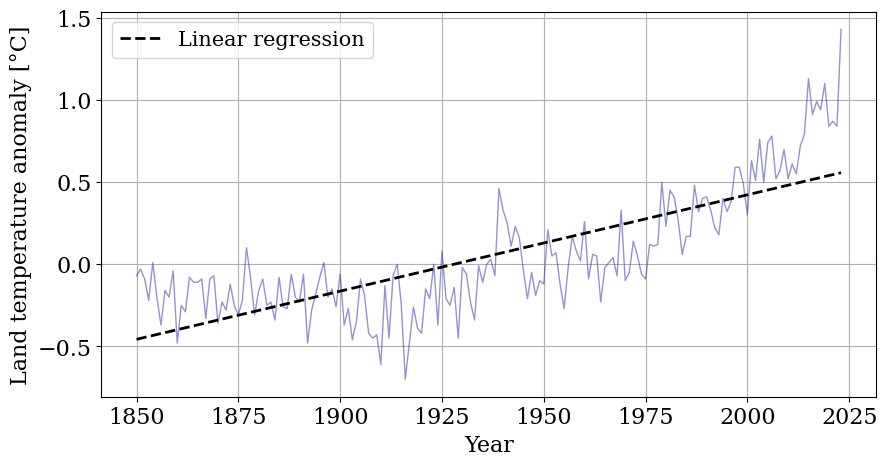

In [19]:
pyplot.figure(figsize=(10, 5))

pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1, alpha=0.5) 
pyplot.plot(year, reg, 'k--', linewidth=2, label='Linear regression')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.legend(loc='best', fontsize=15)
pyplot.grid();

## Step 4: Apply regression using NumPy

Above, we coded linear regression from scratch. But, guess what: we didn't have to because NumPy has built-in functions that do what we need!

Yes! Python and NumPy are here to help! With [`polyfit()`](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html), we get the slope and $y$-intercept of the line that best fits the data. With [`poly1d()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.poly1d.html), we can build the linear function from its slope and $y$-intercept.

Check it out:

In [19]:
# First fit with NumPy, then name the coefficients obtained a_1n, a_0n:
a_1n, a_0n = numpy.polyfit(year, temp_anomaly, 1)

f_linear = numpy.poly1d((a_1n, a_0n)) 

In [20]:
print(a_1n)

0.0103702839435


In [21]:
print(a_0n)

-20.1486853847


In [22]:
print(f_linear)

 
0.01037 x - 20.15


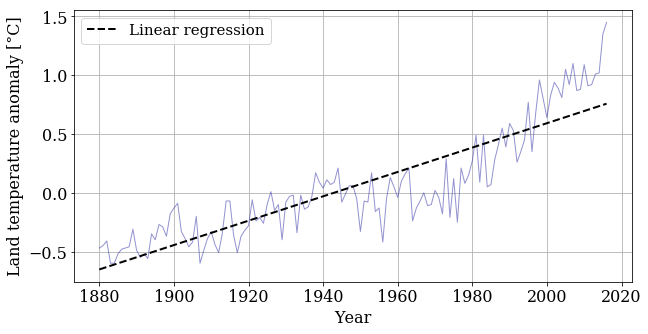

In [23]:
pyplot.figure(figsize=(10, 5))

pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1, alpha=0.5) 
pyplot.plot(year, f_linear(year), 'k--', linewidth=2, label='Linear regression')
pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.legend(loc='best', fontsize=15)
pyplot.grid();

## "Split regression"

If you look at the plot above, you might notice that around 1970 the temperature starts increasing faster that the previous trend. So maybe one single straight line does not give us a good-enough fit.

What if we break the data in two (before and after 1970) and do a linear regression in each segment? 

To do that, we first need to find the position in our `year` array where the year 1970 is located. Thankfully, NumPy has a function called  [`numpy.where()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.where.html) that can help us. We pass a condition and `numpy.where()` tells us where in the array the condition is `True`. 


In [24]:
numpy.where(year==1970)

(array([90]),)

To split the data, we use the powerful instrument of _slicing_ with the colon notation. Remember that a colon between two indices indicates a range of values from a `start` to an `end`. The rule is that `[start:end]` includes the element at index `start` but excludes the one at index `end`. For example, to grab the first 3 years in our `year` array, we do:

In [25]:
year[0:3]

array([ 1880.,  1881.,  1882.])

Now we know how to split our data in two sets, to get two regression lines. We need two slices of the arrays `year` and `temp_anomaly`, which we'll save in new variable names below. After that, we complete two linear fits using the helpful NumPy functions we learned above.

In [26]:
year_1 , temp_anomaly_1 = year[0:90], temp_anomaly[0:90]
year_2 , temp_anomaly_2 = year[90:], temp_anomaly[90:]

m1, b1 = numpy.polyfit(year_1, temp_anomaly_1, 1)
m2, b2 = numpy.polyfit(year_2, temp_anomaly_2, 1)

f_linear_1 = numpy.poly1d((m1, b1))
f_linear_2 = numpy.poly1d((m2, b2))

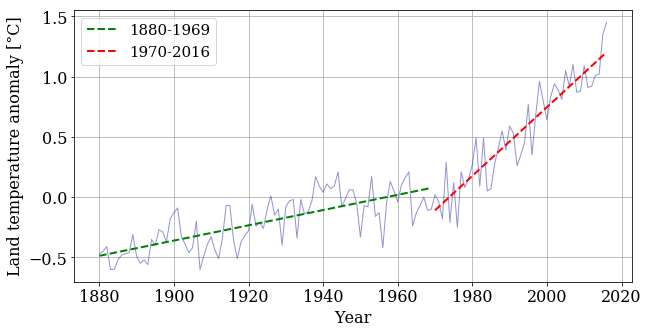

In [27]:
pyplot.figure(figsize=(10, 5))

pyplot.plot(year, temp_anomaly, color='#2929a3', linestyle='-', linewidth=1, alpha=0.5) 
pyplot.plot(year_1, f_linear_1(year_1), 'g--', linewidth=2, label='1880-1969')
pyplot.plot(year_2, f_linear_2(year_2), 'r--', linewidth=2, label='1970-2016')

pyplot.xlabel('Year')
pyplot.ylabel('Land temperature anomaly [°C]')
pyplot.legend(loc='best', fontsize=15)
pyplot.grid();

We have two different curves for two different parts of our data set. A little problem with this and is that the end point of our first regression doesn't match the starting point of the second regression. We did this for the purpose of learning, but it is not rigorously correct. We'll fix in in the next course module when we learn more about different types of regression. 

## We learned:

* Making our plots more beautiful
* Defining and calling custom Python functions
* Applying linear regression to data
* NumPy built-ins for linear regression
* The Earth is warming up!!!

## References

1. [_Essential skills for reproducible research computing_](https://barbagroup.github.io/essential_skills_RRC/) (2017). Lorena A. Barba,  Natalia C. Clementi, Gilbert Forsyth. 
2. _Numerical Methods in Engineering with Python 3_ (2013). Jaan Kiusalaas. Cambridge University Press.
3. _Effective Computation in Physics: Field Guide to Research with Python_ (2015). Anthony Scopatz & Kathryn D. Huff. O'Reilly Media, Inc.


In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
HTML(open('../../../styles/custom.css', "r").read())